In [1]:
import os
import shutil
import random
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime

from sklearn import preprocessing
from sklearn.covariance import OAS
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.kernel_approximation import Nystroem
from sklearn.pipeline import Pipeline
from sklearn.neighbors import LocalOutlierFactor
from utils import print_all_results, save_pickle, show_confusion_matrix, show_parallel_plot

import torch
from torch.optim import RMSprop, Adam, SGD
from torch import nn, Tensor
from torch.utils.data import Dataset, DataLoader, Subset
from torch.utils.tensorboard import SummaryWriter
from itertools import product
from torch.optim.lr_scheduler import ReduceLROnPlateau

random_state = 42

NN_name = "FF"

---
## Preparation

In [2]:
base_dir = "outputs/2_FF_outputs/"
model_dir = base_dir + "models/"
runs_dir = base_dir + "runs/"

# shutil.rmtree(model_dir, ignore_errors=True)
# shutil.rmtree(runs_dir, ignore_errors=True)
# os.makedirs(model_dir, exist_ok=True)
# os.makedirs(runs_dir, exist_ok=True)

### Device


In [3]:
# PyTorch Device
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print("Device: {}".format(device))

Device: cuda


### Set seeds


In [4]:
# For reproducibility, fix all the seeds
def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.
    Args:
        seed: the seed to use.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True  # slower

## Data Layer


In [5]:
class MyDataset(Dataset):
    # Save X and y as Tensors, accordingly to the type of the data
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32, device=device)
        self.y = torch.tensor(y, dtype=torch.float32, device=device)

        self.num_features = X.shape[1]

    # Dataset size
    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx, :], self.y[idx]

## Neural Network Architectures

#### NeuralNetworkSimple
- Hidden layers with ReLU activation function, with same number of neurons per layer.

In [6]:
class NeuralNetworkSimple(nn.Module):
    def __init__(self, input_size, hidden_size, depth):
        super(NeuralNetworkSimple, self).__init__()

        self.input_layer = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
        )

        self.hidden_layers = nn.Sequential(*[nn.Linear(hidden_size, hidden_size), nn.ReLU()] * (depth - 1))

        self.output = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h_in = self.input_layer(x)
        h_out = self.hidden_layers(h_in)
        out = self.output(h_out)
        return out

    def _get_description(self):
        return "[Linear(hidden_size)+ReLU]*depth"

#### NeuralNetworkDropout
- Hidden layers with ReLU activation function and a Dropout layer between each hidden layer, with same number of neurons per layer

In [7]:
class NeuralNetworkDropout(nn.Module):
    def __init__(self, input_size, hidden_size, depth, dropout_rate):
        super(NeuralNetworkDropout, self).__init__()

        self.input_layer = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
        )

        self.hidden_layers = nn.Sequential(
            *[
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
            ]
            * (depth - 1)
        )

        self.output = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h_in = self.input_layer(x)
        h_out = self.hidden_layers(h_in)
        out = self.output(h_out)
        return out

    def _get_description(self):
        return "[Linear(hidden_size)+ReLU+Dropout(dropout_rate)]*depth"

#### NeuralNetworkBatchNorm
- Hidden layers + Batch Normalization with ReLU activation function, with same number of neurons per layer

In [8]:
class NeuralNetworkBatchNorm(nn.Module):
    def __init__(self, input_size, hidden_size, depth):
        super(NeuralNetworkBatchNorm, self).__init__()

        self.input_layer = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
        )

        self.hidden_layers = nn.Sequential(
            *[
                nn.Linear(hidden_size, hidden_size),
                nn.BatchNorm1d(hidden_size),
                nn.ReLU(),
            ]
            * (depth - 1)
        )

        self.output = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h_in = self.input_layer(x)
        h_out = self.hidden_layers(h_in)
        out = self.output(h_out)
        return out

    def _get_description(self):
        return "[Linear(hidden_size)+BatchNorm1d+ReLU]*depth"

#### NeuralNetworkDropoutBatchNorm
- Hidden layers + Batch Normalization with ReLU activation function, and a Dropout layer between each hidden layer, with same number of neurons per layer

In [9]:
class NeuralNetworkDropoutBatchNorm(nn.Module):
    def __init__(self, input_size, hidden_size, depth, dropout_rate):
        super(NeuralNetworkDropoutBatchNorm, self).__init__()

        self.input_layer = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
        )

        self.hidden_layers = nn.Sequential(
            *[
                nn.Linear(hidden_size, hidden_size),
                nn.BatchNorm1d(hidden_size),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
            ]
            * (depth - 1)
        )

        self.output = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h_in = self.input_layer(x)
        h_out = self.hidden_layers(h_in)
        out = self.output(h_out)
        return out

    def _get_description(self):
        return "[Linear(hidden_size)+BatchNorm1d+ReLU+Dropout]*depth"

## Early Stopper
- Stops the training if the validation loss stops improving

In [10]:
class EarlyStopper:
    def __init__(self, patience=1, delta=0):
        self.patience: int = patience
        self.delta: int = delta
        self.counter = 0
        self.min_validation_loss = float("inf")

    def early_stop(self, validation_loss):
        if validation_loss <= (self.min_validation_loss - self.delta):
            self.min_validation_loss = validation_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            # print("\tEarly stopper: {}/{} epochs".format(self.counter, self.patience))
            if self.counter >= self.patience:
                return True

## Train Function

In [11]:
# Function for the training process
def train_model(
    model: nn.Module,  # instance of class to train
    criterion,  # instance of loss function
    optimizer,  # instance of optimizer
    epochs,  # number of
    train_loader: DataLoader,
    val_loader: DataLoader,
    scheduler,
    early_stopper,
    device,  # to train on
    log_writer,
    log_name,
):
    n_iter = 0
    best_valid_loss = float("inf")  # initialized to worst possible value

    # EPOCHS
    for epoch in range(epochs):
        model.train()  # activate training mode (for BatchNorm or Dropout)

        # BATCHES
        for data, targets in train_loader:  # get_item from MyDataset class (single item or batch)
            data, targets = data.to(device), targets.to(device)

            optimizer.zero_grad()  # gradient to zero

            # Forward pass
            y_pred = model(data)

            # Compute Loss
            loss = criterion(y_pred.squeeze(), targets)  # reshape because MSELoss requires same dimensionality
            log_writer.add_scalar("Loss train/batches", loss, n_iter)  # plot the batches

            # Backward pass
            loss.backward()
            optimizer.step()

            n_iter += 1

        # Valuation
        y_test, y_pred = test_model(model, val_loader, device)
        loss_val = criterion(y_pred.squeeze(), y_test)
        log_writer.add_scalar("Loss val/epochs", loss_val, epoch)  # plot the epochs

        scheduler.step(loss_val)

        # Save the model with best loss through the epochs
        if loss_val.item() < best_valid_loss:
            best_valid_loss = loss_val.item()
            torch.save(model.state_dict(), model_dir + log_name)

        # Early Stopping
        if early_stopper.early_stop(loss_val.item()):
            print("Early stopped!")
            break

## Test Function

In [12]:
def test_model(model: nn.Module, data_loader: DataLoader, device) -> tuple[Tensor, Tensor, Tensor]:
    model.eval()  # activate evaluation mode (for BatchNorm or Dropout)

    y_pred = []
    y_test = []

    for data, targets in data_loader:
        data, targets = data.to(device), targets.to(device)

        y_pred.append(model(data))  # accumulate predictions
        y_test.append(targets)  # accumulate labels

    y_test = torch.stack(y_test).squeeze()
    y_pred = torch.stack(y_pred).squeeze()
    return y_test, y_pred

---

## Data Acquisition

- Since the dataset is very imbalanced, "stratify" is set to be sure of having some samples of every class in all the sets.

In [13]:
df = pd.read_csv("train.csv").drop_duplicates()
print("Rows: ", df.shape[0])
print("Columns: ", df.shape[1])

df_X = df.iloc[:, 1:].values
df_y = df.iloc[:, 0].values
indices = np.arange(df_X.shape[0])

# Separate indices in train/val/set (70 train, 20 val, 10 test)
train_idx, test_idx = train_test_split(indices, test_size=0.3, stratify=df_y, random_state=random_state)
val_idx, test_idx = train_test_split(test_idx, test_size=1 / 3, stratify=df_y[test_idx], random_state=random_state)

print("Train: ", len(train_idx))
print("Validation: ", len(val_idx))
print("Test: ", len(test_idx))

Rows:  252123
Columns:  91
Train:  176486
Validation:  50424
Test:  25213


## Outlier Removal

- Remove the outliers from the training set. Observations belonging to different classes (years) are treated differently, as the dataset is so imbalanced: the model for outlier detection is refitted for every year in the dataset.
- It's used [LocalOutlierFactor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html#sklearn.neighbors.LocalOutlierFactor) and [IsolationForest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html#sklearn.ensemble.IsolationForest). The hyperparameters are been chosen during a preliminary search.

- With a "contamination" of 0.001 (200 observations removed) and of 0.01 (1790 observations removed): the neural network performs a little worse but almost equally.
- Incrementing the contamination, the neural network performs worse.

In [14]:
if False:
    columns = [col for col in df.columns if col != "Year"]
    outliers = pd.Series(index=df.reset_index().loc[train_idx].index, dtype=bool)

    for year in df.reset_index().loc[train_idx]["Year"].unique():
        subset = df.reset_index().loc[train_idx][df.reset_index().loc[train_idx]["Year"] == year]
        lof = LocalOutlierFactor(n_neighbors=25, contamination=0.1, n_jobs=-1)
        outliers[subset.index] = lof.fit_predict(subset[columns]) == -1

    print(outliers.sum())
    train_idx = train_idx[~outliers]

17670


## Preprocessing

- With MinMax preprocess (with or without any L-Normalization) the NN can't descend the local minimum of MSE=110
- Using LDA performs a little worse than plain Standard Scaling
- Over some preliminary search, the best preprocess pipeline found is StardardScaling + L2-Normalization

In [15]:
# preprocess_steps = Pipeline([("raw", None)])
# preprocess_name = "RAW"

# preprocess_steps = Pipeline(
#     steps=[
#         ("min-max", preprocessing.MinMaxScaler()),
#         ("l2", preprocessing.Normalizer(norm="l2")),
#     ]
# )
# preprocess_name = "MinMax+L2"

# preprocess_steps = Pipeline(
#     steps=[
#         ("std", preprocessing.StandardScaler()),
#         ("l2", preprocessing.Normalizer(norm="l2")),
#         ("lda", LinearDiscriminantAnalysis(solver="eigen", shrinkage=None, covariance_estimator=OAS())),
#     ]
# )
# preprocess_name = "Std+L2+LDA"

preprocess_steps = Pipeline(
    steps=[
        ("std", preprocessing.StandardScaler()),
        ("l2", preprocessing.Normalizer(norm="l2")),
    ]
)
preprocess_name = "STD+L2"

preprocess_steps.fit(df_X[train_idx], df_y[train_idx])
df_X_t = preprocess_steps.transform(df_X)

## Hyperparameters

In [16]:
num_epochs = [200]

hidden_size = [256]  # 128, 256, 512, 1024]
batch_size = [48]  # [8, 16, 32, 64]
depth = [2]  # [3, 4, 5]
learning_rate = [0.0001]  # [0.001, 0.1]

dropout_rate = [0.1]

criterion = [nn.MSELoss()]  # nn.L1Loss(), nn.HuberLoss()

optimizer = [RMSprop]  # Adam, SGD
momentum = [0.9]

scheduler_patience = [21]
scheduler_threshold = [1]
scheduler_threshold_mode = ["abs"]  # "rel"
scheduler_factor = [0.1]
scheduler_min_lr = [0.0000001]

early_stopper_patience = [20]

hyperparameters = list(
    product(
        hidden_size,
        depth,
        num_epochs,
        batch_size,
        learning_rate,
        criterion,
        optimizer,
        scheduler_patience,
        scheduler_threshold,
        momentum,
        dropout_rate,
        early_stopper_patience,
        scheduler_threshold_mode,
        scheduler_factor,
        scheduler_min_lr,
    )
)
n_comb = len(hyperparameters)
print(f"Combinations size: {n_comb}")

Combinations size: 1


In [17]:
results_tt = pd.DataFrame(
    columns=[
        "ID",
        "R^2",
        "MSE",
        "preprocess",
        "NN_architecture",
        "depth",
        "hidden_size",
        "dropout_rate",
        "batch_size",
        "learning_rate",
        "criterion",
        "optimizer",
        "momentum",
        "scheduler_patience",
        "scheduler_threshold",
        "scheduler_threshold_mode",
        "scheduler_factor",
        "scheduler_min_lr",
        "early_stopper_patience",
        "num_epochs",
    ]
)

## Run

In [18]:
best_loss = np.inf
best_combination = None
best_model = None

for n_iter, (
    hidden_size,
    depth,
    num_epochs,
    batch_size,
    learning_rate,
    criterion,
    optimizer,
    scheduler_patience,
    scheduler_threshold,
    momentum,
    dropout_rate,
    early_stopper_patience,
    scheduler_threshold_mode,
    scheduler_factor,
    scheduler_min_lr,
) in enumerate(hyperparameters):
    fix_random(random_state)
    print("\n=================================================================================")
    print(f"Iteration {n_iter+1}/{n_comb}")

    # Data Loaders
    my_dataset = MyDataset(df_X_t, df_y)
    train_loader = DataLoader(Subset(my_dataset, train_idx), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(Subset(my_dataset, val_idx), batch_size=1)
    test_loader = DataLoader(Subset(my_dataset, test_idx), batch_size=1)

    # Model
    model = NeuralNetworkDropoutBatchNorm(my_dataset.num_features, hidden_size, depth=depth, dropout_rate=dropout_rate)
    model.to(device)

    # Optimizer, Scheduler, Early Stopper
    optimizer = optimizer(model.parameters(), lr=learning_rate, momentum=momentum)
    scheduler = ReduceLROnPlateau(
        optimizer,
        patience=scheduler_patience,
        threshold=scheduler_threshold,
        threshold_mode=scheduler_threshold_mode,
        factor=scheduler_factor,
        min_lr=scheduler_min_lr,
        verbose=True,
    )
    early_stopper = EarlyStopper(patience=early_stopper_patience, delta=0.1)

    # Writer
    log_name = datetime.now().strftime("%Y%m%d-%H%M%S") + str(datetime.now().microsecond // 1000).zfill(3)
    log_writer = SummaryWriter(runs_dir + log_name)

    # Save configuration to df
    results_tt.loc[len(results_tt)] = [
        log_name,
        None,
        None,
        preprocess_name,
        model._get_description(),
        depth,
        hidden_size,
        dropout_rate,
        batch_size,
        learning_rate,
        criterion,
        optimizer.__class__.__name__,
        momentum,
        scheduler_patience,
        scheduler_threshold,
        scheduler_threshold_mode,
        scheduler_factor,
        scheduler_min_lr,
        early_stopper_patience,
        num_epochs,
    ]
    print(results_tt.loc[len(results_tt) - 1])

    # Train
    train_model(
        model,
        criterion,
        optimizer,
        num_epochs,
        train_loader,
        val_loader,
        scheduler,
        early_stopper,
        device,
        log_writer,
        log_name,
    )

    # Load best model (saven in the train function)
    model.load_state_dict(torch.load(model_dir + log_name))
    model.to(device)

    # Test
    y_true, y_pred = test_model(model, test_loader, device)
    test_loss = criterion(y_pred, y_true)
    print(f"\nTest loss (for given criterion): {test_loss:.4f}")
    r2 = r2_score(y_true.cpu().detach().numpy(), y_pred.cpu().detach().numpy())
    mse = mean_squared_error(y_true.cpu().detach().numpy(), y_pred.cpu().detach().numpy())
    print(f"R^2: {r2:.4f}, MSE:{mse:.4f}")

    # Add results to csv
    results_tt.loc[len(results_tt) - 1, "R^2"] = r2
    results_tt.loc[len(results_tt) - 1, "MSE"] = mse
    results_tt.loc[[len(results_tt) - 1]].to_csv("outputs/2_FF_output.csv", mode="a", index=False, header=False)

    if test_loss < best_loss:
        best_model = model
        best_combination = results_tt.loc[len(results_tt) - 1]

    log_writer.flush()
    log_writer.close()


Iteration 1/1
ID                                                         20240210-035142381
R^2                                                                      None
MSE                                                                      None
preprocess                                                             STD+L2
NN_architecture             [Linear(hidden_size)+BatchNorm1d+ReLU+Dropout]...
depth                                                                       2
hidden_size                                                               256
dropout_rate                                                              0.1
batch_size                                                                 48
learning_rate                                                          0.0001
criterion                                                           MSELoss()
optimizer                                                             RMSprop
momentum                                         

## Best result

In [19]:
print(best_combination)

ID                                                         20240210-035142381
R^2                                                                  0.336073
MSE                                                                  73.08065
preprocess                                                             STD+L2
NN_architecture             [Linear(hidden_size)+BatchNorm1d+ReLU+Dropout]...
depth                                                                       2
hidden_size                                                               256
dropout_rate                                                              0.1
batch_size                                                                 48
learning_rate                                                          0.0001
criterion                                                           MSELoss()
optimizer                                                             RMSprop
momentum                                                        

In [20]:
save_pickle(2, NN_name, preprocess_steps, best_model)

## Confusion Matrix

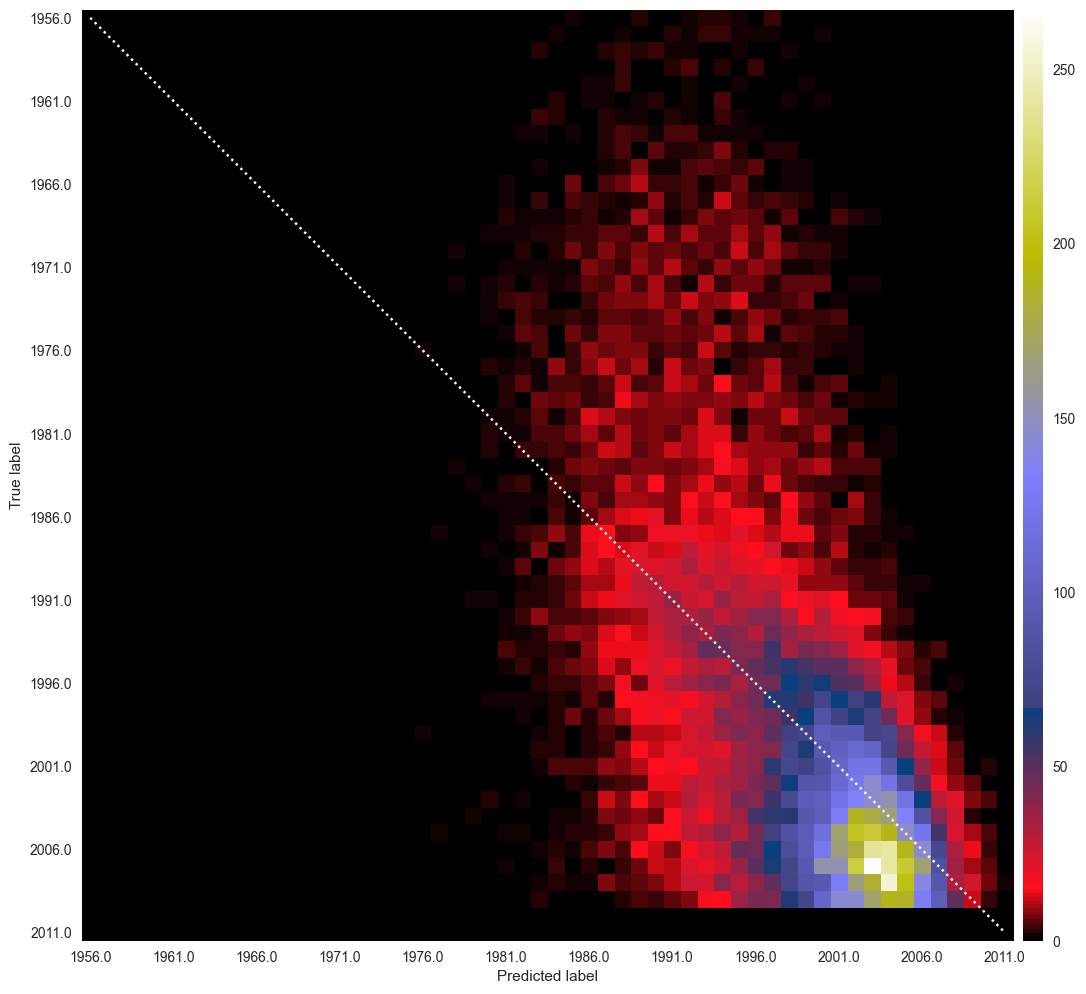

In [22]:
y_true, y_pred = test_model(best_model, test_loader, device)
show_confusion_matrix(y_true.cpu().detach().numpy(), y_pred.cpu().detach().numpy())

## All results

In [23]:
print_all_results(2, NN_name)

,ID,preprocess,NN_architecture,depth,hidden_size,dropout_rate,batch_size,learning_rate,criterion,optimizer,momentum,scheduler_patience,scheduler_threshold,scheduler_threshold_mode,scheduler_factor,scheduler_min_lr,early_stopper_patience,num_epochs,MSE,R^2
57,20240208-072156568,STD+L2,[Linear(hidden_size)+BatchNorm1d+ReLU+Dropout]*depth,2,256,0.1000000,48,0.0001000,MSELoss(),RMSprop,0.9000000,21,1,abs,0.1000000,0.0000001,200,200,70.9346700,0.3555687
54,20240208-051928590,STD+L2,[Linear(hidden_size)+BatchNorm1d+ReLU+Dropout]*depth,2,256,0.1000000,48,0.0001000,MSELoss(),RMSprop,0.9000000,21,1,abs,0.1000000,0.0000000,30,200,70.9346700,0.3555687
53,20240208-043844985,STD+L2,[Linear(hidden_size)+BatchNorm1d+ReLU+Dropout]*depth,2,256,0.1000000,48,0.0001000,MSELoss(),RMSprop,0.9000000,21,1,abs,0.1000000,0.0000000,20,200,70.9346700,0.3555687
47,20240208-014736321,STD+L2,[Linear(hidden_size)+BatchNorm1d+ReLU+Dropout]*depth,2,256,0.1000000,48,0.0001000,MSELoss(),RMSprop,0.9000000,21,1,abs,0.1000000,0.0000001,15,200,71.2149000,0.3530227
49,20240208-025527765,STD+L2,[Linear(hidden_size)+BatchNorm1d+ReLU+Dropout]*depth,2,256,0.1000000,48,0.0001000,MSELoss(),RMSprop,0.9000000,23,1,abs,0.1000000,0.0000001,15,200,71.2548600,0.3526596
48,20240208-022456512,STD+L2,[Linear(hidden_size)+BatchNorm1d+ReLU+Dropout]*depth,2,256,0.1000000,48,0.0001000,MSELoss(),RMSprop,0.9000000,22,1,abs,0.1000000,0.0000001,15,200,71.2663650,0.3525551
46,20240208-011702888,STD+L2,[Linear(hidden_size)+BatchNorm1d+ReLU+Dropout]*depth,2,256,0.1000000,48,0.0001000,MSELoss(),RMSprop,0.9000000,19,1,abs,0.1000000,0.0000001,15,200,71.2971650,0.3522753
45,20240208-004258554,STD+L2,[Linear(hidden_size)+BatchNorm1d+ReLU+Dropout]*depth,2,256,0.1000000,48,0.0001000,MSELoss(),RMSprop,0.9000000,20,1,abs,0.1000000,0.0000001,15,200,71.3070100,0.3521859
44,20240208-001306254,STD+L2,[Linear(hidden_size)+BatchNorm1d+ReLU+Dropout]*depth,2,256,0.1000000,48,0.0001000,MSELoss(),RMSprop,0.9000000,15,1,abs,0.1000000,0.0000001,15,200,71.3986700,0.3513533
38,20240207-204322677,STD+L2,[Linear(hidden_size)+BatchNorm1d+ReLU+Dropout]*depth,2,256,0.1000000,48,0.0001000,MSELoss(),RMSprop,0.9000000,200,1,abs,0.1000000,0.0000001,200,200,71.4760360,0.3506504


In [25]:
show_parallel_plot(2, NN_name)